In [ ]:
!pip install adversarial-robustness-toolbox

### FGSM Attack on CNN Model

In [ ]:
from keras.models import load_model
model = load_model('/content/cnn_20_epochs.h5')

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import LambdaCallback
import tensorflow.keras.layers as L
from tensorflow.keras.datasets import mnist, cifar10

import numpy as np
import matplotlib.pyplot as plt
from random import randint
from tqdm import tqdm
import time

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


In [ ]:
X_train = X_train / 255.0
X_test = X_test / 255.0

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [ ]:
height, width, channels = 32, 32, 3
nb_classes = 10
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
               'horse', 'ship', 'truck']



X_train = X_train.reshape((-1, height, width, channels))
X_test = X_test.reshape((-1, height, width, channels))

y_train = tf.keras.utils.to_categorical(y_train, nb_classes)
y_test = tf.keras.utils.to_categorical(y_test, nb_classes)


### Fast Gradient Signed Method (FGSM) attack to perturb images

In [ ]:
def generate_adversary(image, label, epsilon=0.1):
  image = tf.cast(image, tf.float32)

  with tf.GradientTape() as tape:
    tape.watch(image)
    prediction = model(image)
    loss = tf.keras.losses.MSE(label, prediction)
  gradient = tape.gradient(loss, image)
  sign_grad = tf.sign(gradient)
  perturbation = epsilon * sign_grad  # Apply epsilon to the sign gradient

  return perturbation

In [ ]:
height, width, channels = 32, 32, 3

Prediction from CNN: ship


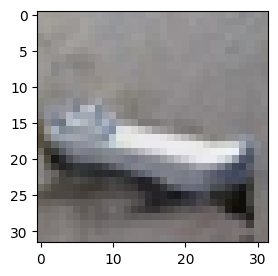

In [ ]:
# Testing on random image
rand_idx = randint(0,49999)
image = X_train[rand_idx].reshape((1, height, width, channels))
label = y_train[rand_idx]

print(f'Prediction from CNN: {label_names[np.where(label==1)[0][0]]}')
plt.figure(figsize=(3,3))
plt.imshow(image.reshape((height, width, channels)))
plt.show()

In [ ]:
# Adding perturbations
perturbations = generate_adversary(image,label,0.2).numpy()
adversarial = image + (perturbations * 0.05)

1/1 [==============================] - 0s 39ms/step
Original Image Prediction: ship
1/1 [==============================] - 0s 45ms/step
Adversary Prediction: airplane


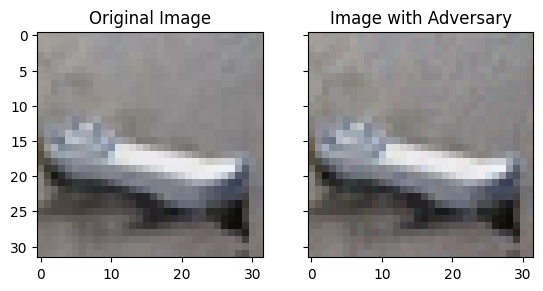

In [ ]:
from art.estimators.classification import KerasClassifier
# Comparing images
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True)
print(f'Original Image Prediction: {label_names[model.predict(image).argmax()]}')
ax1.imshow(image.reshape(height,width, channels))
ax1.set_title("Original Image")
print(f"Adversary Prediction: {label_names[model.predict(adversarial).argmax()]}")
ax2.imshow(adversarial.reshape(height,width, channels))
ax2.set_title("Image with Adversary")
plt.show()

In [ ]:
print(f'Normal Image Prediction: {label_names[model.predict(image).argmax()]}')
print(f"Adversary Prediction: {label_names[model.predict(adversarial).argmax()]}")

1/1 [==============================] - 0s 33ms/step
Normal Image Prediction: bird
1/1 [==============================] - 0s 31ms/step
Adversary Prediction: frog


In [ ]:
def adversary_generator(batch_size):
  while True:
    images = []
    labels = []
    for batch in range(batch_size):
      label = y_test[batch]
      image = X_test[batch].reshape((1,height, width, channels))

      perturbations = generate_adversary(image, label,0.2).numpy()
      adversarial = image + (perturbations * 0.2)

      images.append(adversarial)
      labels.append(label)

      if batch%1000 == 0:
        print(f"{batch} images generated")

    images = np.asarray(images).reshape((batch_size, height, width, channels))
    labels = np.asarray(labels)

    yield images, labels

In [ ]:
# Testing model accuracy on perturbed images
start = time.time()
x_adversarial_1, y_adversarial_1 = next(adversary_generator(10000))
ad_acc = model.evaluate(x_adversarial_1, y_adversarial_1, verbose=0)
print(f"Accuracy on Adversarial Examples: {ad_acc[1]*100}")
print("Total time: ", time.time() - start, "seconds")

0 images generated
1000 images generated
2000 images generated
3000 images generated
4000 images generated
5000 images generated
6000 images generated
7000 images generated
8000 images generated
9000 images generated
Accuracy on Adversarial Examples: 5.909999832510948
Total time:  415.5088949203491 seconds


# Checking transferability of perturbed images on VGG Dropout,VGG Augm,Resnet 50, Resnet 101 on CNN

In [ ]:
x_adversarial_v1=np.load('/content/X_VGG_adv_FGSM.npy')

In [ ]:
ad_acc = model.evaluate(x_adversarial_v1, y_test, verbose=0)
print(f"Accuracy on Adversarial Examples from VGG Dropout on CNN: {ad_acc[1]*100}")

Accuracy on Adversarial Examples from VGG Dropout on CNN: 35.08999943733215


In [ ]:
x_adversarial_va1=np.load('/content/X_VGG_augm_adv_FGSM.npy')

In [ ]:
ad_acc = model.evaluate(x_adversarial_va1, y_test, verbose=0)
print(f"Accuracy on Adversarial Examples from VGG data augm on CNN: {ad_acc[1]*100}")

Accuracy on Adversarial Examples from VGG data augm on CNN: 20.720000565052032


In [ ]:
np.shape(x_adversarial_res50_1)

(10000, 32, 32, 3)

In [ ]:
x_adversarial_res50_1=np.load('/content/X_Resnet50_adv_FGSM.npy')
ad_acc = model.evaluate(x_adversarial_res50_1, y_test, verbose=0)
print(f"Accuracy on Adversarial Examples from Resnet 50 on CNN: {ad_acc[1]*100}")

Accuracy on Adversarial Examples from Resnet 50 on CNN: 48.44000041484833


In [ ]:
x_adversarial_res101_1=np.load('/content/X_Resnet101_adv_FGSM.npy')
ad_acc = model.evaluate(x_adversarial_res101_1, y_test, verbose=0)
print(f"Accuracy on Adversarial Examples from Resnet 101 on CNN: {ad_acc[1]*100}")

Accuracy on Adversarial Examples from Resnet 101 on CNN: 48.010000586509705


In [ ]:
np.save('X_CNN_adv_FGSM.npy', x_adversarial_1)
np.save('Y_CNN_adv_FGSMl.npy', y_adversarial_1)

In [ ]:
x_adversarial_1=np.load('/content/X_CNN_adv_FGSM.npy')

In [ ]:
predictions_1 = model.predict(x_adversarial_1)
predicted_labels_1 = np.argmax(predictions_1, axis=1)
np.save('Y_CNN_adv_FGSM_predicted_labels.npy', predicted_labels_1)

313/313 [==============================] - 13s 43ms/step


### For VGG Dropout Data Augmentation model

In [ ]:
from keras.models import load_model
model = load_model('/content/VGG_dropout_augm_batch.h5')

In [ ]:
def generate_adversary(image, label, epsilon=0.1):
  image = tf.cast(image, tf.float32)

  with tf.GradientTape() as tape:
    tape.watch(image)
    prediction = model(image)
    loss = tf.keras.losses.MSE(label, prediction)
  gradient = tape.gradient(loss, image)
  sign_grad = tf.sign(gradient)
  perturbation = epsilon * sign_grad  # Apply epsilon to the sign gradient

  return perturbation

Prediction from VGG_droppout_augm_batch: bird


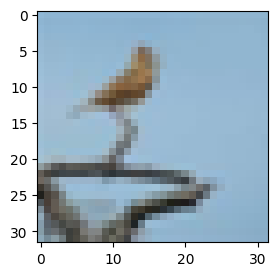

In [ ]:
# Testing on random image
rand_idx = randint(0,49999)
image = X_train[rand_idx].reshape((1, height, width, channels))
label = y_train[rand_idx]

print(f'Prediction from VGG_droppout_augm_batch: {label_names[np.where(label==1)[0][0]]}')
plt.figure(figsize=(3,3))
plt.imshow(image.reshape((height, width, channels)))
plt.show()

In [ ]:
# Adding perturbations
perturbations = generate_adversary(image,label,0.2).numpy()
adversarial = image + (perturbations * 0.05)

1/1 [==============================] - 0s 28ms/step
Original Image Prediction: bird
1/1 [==============================] - 0s 25ms/step
Adversary Prediction: airplane


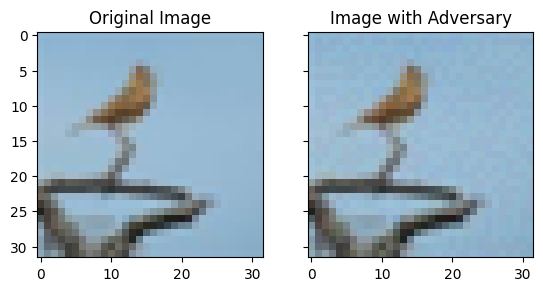

In [ ]:
from art.estimators.classification import KerasClassifier
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True)
print(f'Original Image Prediction: {label_names[model.predict(image).argmax()]}')
ax1.imshow(image.reshape(height,width, channels))
ax1.set_title("Original Image")
print(f"Adversary Prediction: {label_names[model.predict(adversarial).argmax()]}")
ax2.imshow(adversarial.reshape(height,width, channels))
ax2.set_title("Image with Adversary")
plt.show()

In [ ]:
print(f'Normal Image Prediction: {label_names[model.predict(image).argmax()]}')
print(f"Adversary Prediction: {label_names[model.predict(adversarial).argmax()]}")

1/1 [==============================] - 0s 35ms/step
Normal Image Prediction: truck
1/1 [==============================] - 0s 32ms/step
Adversary Prediction: automobile


In [ ]:
def adversary_generator(batch_size):
  while True:
    images = []
    labels = []
    for batch in range(batch_size):
      label = y_test[batch]
      image = x_test[batch].reshape((1,height, width, channels))

      perturbations = generate_adversary(image, label,0.2).numpy()
      adversarial = image + (perturbations * 0.2)

      images.append(adversarial)
      labels.append(label)

      if batch%1000 == 0:
        print(f"{batch} images generated")

    images = np.asarray(images).reshape((batch_size, height, width, channels))
    labels = np.asarray(labels)

    yield images, labels

In [ ]:
x_adversarial_2, y_adversarial_2 = next(adversary_generator(10000))
ad_acc = model.evaluate(x_adversarial_2, y_adversarial_2, verbose=0)
print(f"Accuracy on Adversarial Examples: {ad_acc[1]*100}")

0 images generated
1000 images generated
2000 images generated
3000 images generated
4000 images generated
5000 images generated
6000 images generated
7000 images generated
8000 images generated
9000 images generated
Accuracy on Adversarial Examples: 4.509999975562096


# Checking transferability of perturbed images on CNN, VGG Dropout, Resnet 50, Resnet 101 on VGG augm

In [ ]:
x_adversarial_c1=np.load('/content/X_CNN_adv_FGSM.npy')

In [ ]:
ad_acc = model.evaluate(x_adversarial_c1, y_test, verbose=0)
print(f"Accuracy on Adversarial Examples from CNN on VGG data augm: {ad_acc[1]*100}")

Accuracy on Adversarial Examples from CNN on VGG data augm: 18.790000677108765


In [ ]:
x_adversarial_v2=np.load('/content/X_VGG_adv_FGSM.npy')

In [ ]:
ad_acc = model.evaluate(x_adversarial_v2, y_test, verbose=0)
print(f"Accuracy on Adversarial Examples from VGG Dropout on VGG data augm: {ad_acc[1]*100}")

Accuracy on Adversarial Examples from VGG Dropout on VGG data augm: 31.549999117851257


In [ ]:
x_adversarial_res50_2=np.load('/content/X_Resnet50_adv_FGSM.npy')
ad_acc = model.evaluate(x_adversarial_res50_2, y_test, verbose=0)
print(f"Accuracy on Adversarial Examples from Resnet 50 on VGG data augm: {ad_acc[1]*100}")

Accuracy on Adversarial Examples from Resnet 50 on VGG data augm: 43.23999881744385


In [ ]:
x_adversarial_res101_2=np.load('/content/X_Resnet101_adv_FGSM.npy')
ad_acc = model.evaluate(x_adversarial_res101_2, y_test, verbose=0)
print(f"Accuracy on Adversarial Examples from Resnet 101 on VGG data augm: {ad_acc[1]*100}")

Accuracy on Adversarial Examples from Resnet 101 on VGG data augm: 42.16000139713287


In [ ]:
np.save('X_VGG_augm_adv_FGSM.npy', x_adversarial_2)
np.save('Y_VGG_augm_adv_FGSM.npy', y_adversarial_2)

In [ ]:
x_adversarial_2=np.load('/content/X_VGG_augm_adv_FGSM.npy')

In [ ]:
predictions_2 = model.predict(x_adversarial_2)
predicted_labels_2 = np.argmax(predictions_2, axis=1)
np.save('Y_VGG_augm_adv_FGSM_predicted_labels.npy', predicted_labels_2)

313/313 [==============================] - 16s 51ms/step


### For VGG Dropout Batch Normalization Model

In [ ]:
from keras.models import load_model
model = load_model('/content/VGG_dropout.h5')

In [ ]:
def generate_adversary(image, label, epsilon=0.1):
  image = tf.cast(image, tf.float32)

  with tf.GradientTape() as tape:
    tape.watch(image)
    prediction = model(image)
    loss = tf.keras.losses.MSE(label, prediction)
  gradient = tape.gradient(loss, image)
  sign_grad = tf.sign(gradient)
  perturbation = epsilon * sign_grad  # Apply epsilon to the sign gradient

  return perturbation

Prediction from VGG_droppout_augm_batch: automobile


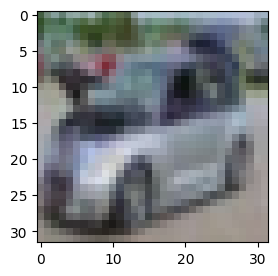

In [ ]:
# Testing on random image
rand_idx = randint(0,49999)
image = X_train[rand_idx].reshape((1, height, width, channels))
label = y_train[rand_idx]

print(f'Prediction from VGG_droppout_augm_batch: {label_names[np.where(label==1)[0][0]]}')
plt.figure(figsize=(3,3))
plt.imshow(image.reshape((height, width, channels)))
plt.show()

In [ ]:
# Adding perturbations
perturbations = generate_adversary(image,label,0.2).numpy()
adversarial = image + (perturbations * 0.05)

1/1 [==============================] - 0s 27ms/step
Original Image Prediction: automobile
1/1 [==============================] - 0s 28ms/step
Adversary Prediction: truck


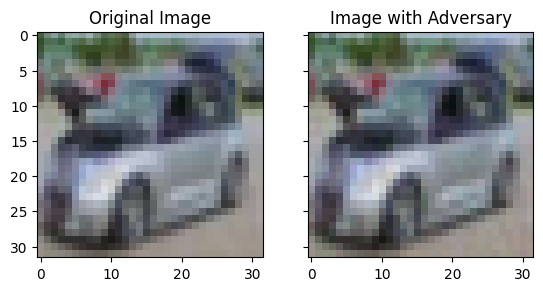

In [ ]:
from art.estimators.classification import KerasClassifier
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True)
print(f'Original Image Prediction: {label_names[model.predict(image).argmax()]}')
ax1.imshow(image.reshape(height,width, channels))
ax1.set_title("Original Image")
print(f"Adversary Prediction: {label_names[model.predict(adversarial).argmax()]}")
ax2.imshow(adversarial.reshape(height,width, channels))
ax2.set_title("Image with Adversary")
plt.show()

In [ ]:
print(f'Normal Image Prediction: {label_names[model.predict(image).argmax()]}')
print(f"Adversary Prediction: {label_names[model.predict(adversarial).argmax()]}")

1/1 [==============================] - 0s 23ms/step
Normal Image Prediction: horse
1/1 [==============================] - 0s 20ms/step
Adversary Prediction: cat


In [ ]:
def adversary_generator(batch_size):
  while True:
    images = []
    labels = []
    for batch in range(batch_size):
      label = y_test[batch]
      image = x_test[batch].reshape((1,height, width, channels))

      perturbations = generate_adversary(image, label,0.2).numpy()
      adversarial = image + (perturbations * 0.2)

      images.append(adversarial)
      labels.append(label)

      if batch%1000 == 0:
        print(f"{batch} images generated")

    images = np.asarray(images).reshape((batch_size, height, width, channels))
    labels = np.asarray(labels)

    yield images, labels


In [ ]:
x_adversarial, y_adversarial = next(adversary_generator(10000))
ad_acc = model.evaluate(x_adversarial, y_adversarial, verbose=0)
print(f"Accuracy on Adversarial Examples: {ad_acc[1]*100}")

0 images generated
1000 images generated
2000 images generated
3000 images generated
4000 images generated
5000 images generated
6000 images generated
7000 images generated
8000 images generated
9000 images generated
Accuracy on Adversarial Examples: 15.6700000166893


# Checking transferability of perturbed images on CNN and VGG Data augm on VGG Dropout

In [ ]:
x_adversarial_c2=np.load('/content/X_CNN_adv_FGSM.npy')

In [ ]:
ad_acc = model.evaluate(x_adversarial_c1, y_test, verbose=0)
print(f"Accuracy on Adversarial Examples from CNN on VGG Dropout: {ad_acc[1]*100}")

Accuracy on Adversarial Examples from CNN on VGG Dropout: 34.00000035762787


In [ ]:
x_adversarial_va2=np.load('/content/X_VGG_augm_adv_FGSM.npy')

In [ ]:
ad_acc = model.evaluate(x_adversarial_va2, y_test, verbose=0)
print(f"Accuracy on Adversarial Examples from VGG Data augm on VGG Dropout: {ad_acc[1]*100}")

Accuracy on Adversarial Examples from VGG Data augm on VGG Dropout: 36.23000085353851


In [ ]:
x_adversarial_res50_3=np.load('/content/X_Resnet50_adv_FGSM.npy')
ad_acc = model.evaluate(x_adversarial_res50_3, y_test, verbose=0)
print(f"Accuracy on Adversarial Examples from Resnet 50 on VGG Dropout: {ad_acc[1]*100}")

Accuracy on Adversarial Examples from Resnet 50 on VGG Dropout: 66.3100004196167


In [ ]:
x_adversarial_res101_3=np.load('/content/X_Resnet101_adv_FGSM.npy')
ad_acc = model.evaluate(x_adversarial_res101_3, y_test, verbose=0)
print(f"Accuracy on Adversarial Examples from Resnet 101 on VGG Dropout: {ad_acc[1]*100}")

Accuracy on Adversarial Examples from Resnet 101 on VGG Dropout: 64.37000036239624


In [ ]:
predictions = model.predict(x_adversarial)
predicted_labels = np.argmax(predictions, axis=1)
np.save('Y_Resnet50_adv_FGSM.npy', predicted_labels)

In [ ]:
np.save('X_VGG_adv_FGSM.npy', x_adversarial)
np.save('Y_VGG_adv_FGSM.npy', y_adversarial)

In [ ]:
x_adversarial_3=np.load('/content/X_VGG_adv_FGSM.npy')

In [ ]:
predictions_3 = model.predict(x_adversarial_3)
predicted_labels_3 = np.argmax(predictions_3, axis=1)
np.save('Y_VGG_adv_FGSM_predicted_labels.npy', predicted_labels_3)

313/313 [==============================] - 12s 38ms/step
